<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 7.13 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:52:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 6.8 MB/s 
     |████████████████████████████████| 170 kB 37.6 MB/s 
     |████████████████████████████████| 138 kB 36.0 MB/s 
     |████████████████████████████████| 133 kB 40.6 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 62 kB 948 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 64psrclh
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/64psrclh


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: jdrh9f1w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
31/31 [==============================] - 36s 45ms/step - loss: 3.7019 - mean_squared_error: 3.7019 - mean_absolute_error: 0.8969 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1746
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.2005 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.2054
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1536 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1265
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0954 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1315
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_err

epoch,57
loss,0.00304
mean_squared_error,0.00304
mean_absolute_error,0.04137
val_loss,0.01107
val_mean_squared_error,0.01107
val_mean_absolute_error,0.0874
_runtime,54
_timestamp,1626893604
_step,57
best_val_loss,0.00992


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▆█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▆█▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▁▁▁▁▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ghqjqmu8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 57ms/step - loss: 0.2284 - mean_squared_error: 0.2284 - mean_absolute_error: 0.3450 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1606
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0674 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1627
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0560 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1503
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1449
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_erro

epoch,70
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02261
val_loss,0.01329
val_mean_squared_error,0.01329
val_mean_absolute_error,0.09172
_runtime,17
_timestamp,1626893641
_step,70
best_val_loss,0.01087


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▂▂▁▁▁▂▁▁▁▁▂▂
val_mean_squared_error,██▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▂▂▁▁▁▂▁▁▁▁▂▂
val_mean_absolute_error,██▆▅▅▅▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▂▁▁▁▂▁▁▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w6cwswvn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 55ms/step - loss: 1.5916 - mean_squared_error: 1.5916 - mean_absolute_error: 0.5802 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1377
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0420 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1405
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0689 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1470
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0656 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1372
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0141 - mean_squared_erro

epoch,42
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.03883
val_loss,0.02156
val_mean_squared_error,0.02156
val_mean_absolute_error,0.11745
_runtime,11
_timestamp,1626893668
_step,42
best_val_loss,0.01369


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▂▃▃▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▃▃█▄▃▄▂▃▆▄▂▄▁▁▁▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_squared_error,▃▃▃▃█▄▃▄▂▃▆▄▂▄▁▁▁▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,▃▃▄▃█▅▄▄▂▃▇▄▃▄▂▂▂▃▂▂▁▂▁▂▂▂▁▃▂▂▁▁▁▃▂▁▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: hnjletva with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 62ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1206 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1271
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0499 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1182
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0644 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1167
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0399 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1150
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_err

epoch,77
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02419
val_loss,0.01043
val_mean_squared_error,0.01043
val_mean_absolute_error,0.08405
_runtime,21
_timestamp,1626893696
_step,77
best_val_loss,0.00859


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▄▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▄▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▆▂▂▄▂▂▂▃▁▂▂▂▃▂▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▆▄▃▃▄▄▂▂▆▂▂▂▂▂▂▁▂▂▁▁▂▁▄▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_squared_error,█▆▆▄▃▃▄▄▂▂▆▂▂▂▂▂▂▁▂▂▁▁▂▁▄▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▆▅▄▃▄▄▃▂▆▂▂▂▂▂▂▂▂▂▁▂▂▁▅▁▁▂▂▁▁▁▂▁▁▂▁▁▂▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wgi3jegp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 32ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1060 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1315
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0508 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1161
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0506 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1050
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0441 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1022
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_erro

epoch,74
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02108
val_loss,0.00851
val_mean_squared_error,0.00851
val_mean_absolute_error,0.07298
_runtime,26
_timestamp,1626893729
_step,74
best_val_loss,0.00816


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▂▂▂▂▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▃▂▂▂▂▂▂▂▃▂▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9axv22rl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 59ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.2041 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1416
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0799 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1604
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1385
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1304
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_erro

epoch,77
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02096
val_loss,0.00969
val_mean_squared_error,0.00969
val_mean_absolute_error,0.07667
_runtime,18
_timestamp,1626893774
_step,77
best_val_loss,0.00877


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wt87286a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 0.2386 - mean_squared_error: 0.2386 - mean_absolute_error: 0.3950 - val_loss: 0.1707 - val_mean_squared_error: 0.1707 - val_mean_absolute_error: 0.3462
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - mean_absolute_error: 0.2566 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.2061
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1722 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1595
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1401 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1508
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0195 - mean_squared_error: 0.

epoch,33
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.04278
val_loss,0.02682
val_mean_squared_error,0.02682
val_mean_absolute_error,0.136
_runtime,11
_timestamp,1626893800
_step,33
best_val_loss,0.02656


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: iki641jo with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 62ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - mean_absolute_error: 0.1812 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1267
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1254
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0441 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1128
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0390 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1026
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_erro

epoch,71
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02677
val_loss,0.00859
val_mean_squared_error,0.00859
val_mean_absolute_error,0.07279
_runtime,19
_timestamp,1626893829
_step,71
best_val_loss,0.00839


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▃▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
val_mean_squared_error,██▄▃▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
val_mean_absolute_error,██▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▃▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hgzuv78w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 32ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - mean_absolute_error: 0.2265 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1312
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0500 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1358
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0393 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1350
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1325
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_squared_erro

epoch,199
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.0251
val_loss,0.01334
val_mean_squared_error,0.01334
val_mean_absolute_error,0.09221
_runtime,50
_timestamp,1626893896
_step,199
best_val_loss,0.01305


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kvd058gh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 34ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1296 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1339
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0374 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1187
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0335 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1119
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0347 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1033
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_erro

epoch,70
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02183
val_loss,0.01005
val_mean_squared_error,0.01005
val_mean_absolute_error,0.07701
_runtime,27
_timestamp,1626893931
_step,70
best_val_loss,0.00876


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▃▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▃▂▃▂▂▃▁▁▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▂
val_mean_squared_error,█▆▄▅▃▂▃▂▂▃▁▁▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▂
val_mean_absolute_error,█▆▄▅▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a5cx67wu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 178ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - mean_absolute_error: 0.3453 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - val_mean_absolute_error: 0.2105
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1471 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1399
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0995 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1666
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.1095 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1415
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0075

epoch,15
loss,0.00306
mean_squared_error,0.00306
mean_absolute_error,0.0426
val_loss,0.02332
val_mean_squared_error,0.02332
val_mean_absolute_error,0.1259
_runtime,9
_timestamp,1626893968
_step,15
best_val_loss,0.02318


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁██████
_timestamp,▁▁▁▁▁▁▁▁▁▁██████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 05tnin6u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.2754 - mean_squared_error: 0.2754 - mean_absolute_error: 0.2820 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - val_mean_absolute_error: 0.2421
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0928 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1289
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0413 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1696
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0909 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1387
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_err

epoch,79
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.02486
val_loss,0.01176
val_mean_squared_error,0.01176
val_mean_absolute_error,0.08542
_runtime,21
_timestamp,1626893998
_step,79
best_val_loss,0.01044


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▄▃▄▂▂▂▂▃▄▁▃▁▁▂▅▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▄▃▄▂▂▂▂▃▄▁▃▁▁▂▅▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▅▂▂▂▂▃▅▂▃▂▁▂▆▂▂▁▁▃▁▁▂▁▂▁▂▁▁▂▁▁▂▁▃▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 28w39pqf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 187ms/step - loss: 0.2530 - mean_squared_error: 0.2530 - mean_absolute_error: 0.3258 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1354
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0426 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1287
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0577 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1659
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0876 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1219
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0

epoch,15
loss,0.00381
mean_squared_error,0.00381
mean_absolute_error,0.04882
val_loss,0.02154
val_mean_squared_error,0.02154
val_mean_absolute_error,0.11585
_runtime,11
_timestamp,1626894017
_step,15
best_val_loss,0.02013


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▃▁▁▃▂▁▁▂▁▁▁▂▂
val_loss,▃▂█▁▁▁▃▁▂▃▂▂▂▂▃▁
val_mean_squared_error,▃▂█▁▁▁▃▁▂▃▂▂▂▂▃▁
val_mean_absolute_error,▄▃█▂▂▁▄▁▁▃▁▁▁▂▃▁
_runtime,▁▅▅▅▅▅▅▅████████
_timestamp,▁▅▅▅▅▅▅▅████████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: f0dhufxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 135ms/step - loss: 0.2747 - mean_squared_error: 0.2747 - mean_absolute_error: 0.4028 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1782
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1192 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1416
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0695 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1337
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0543 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1535
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042 -

epoch,49
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02579
val_loss,0.01372
val_mean_squared_error,0.01372
val_mean_absolute_error,0.09366
_runtime,15
_timestamp,1626894041
_step,49
best_val_loss,0.01359


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▆▅▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▆▅▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▆▅▄▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m6oebj7a with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 122ms/step - loss: 2.4461 - mean_squared_error: 2.4461 - mean_absolute_error: 1.0610 - val_loss: 0.1208 - val_mean_squared_error: 0.1208 - val_mean_absolute_error: 0.2903
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - mean_absolute_error: 0.3316 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.1977
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1917 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1883
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1074 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1345
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0063 - mean_squared_error: 0.00

epoch,99
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.01993
val_loss,0.00871
val_mean_squared_error,0.00871
val_mean_absolute_error,0.07377
_runtime,19
_timestamp,1626894072
_step,99
best_val_loss,0.00861


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pfqu0quq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 126ms/step - loss: 8.0613 - mean_squared_error: 8.0613 - mean_absolute_error: 1.7542 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1727
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1031 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1485
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0879 - val_loss: 0.0618 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.2019
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0955 - mean_squared_error: 0.0955 - mean_absolute_error: 0.2721 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1545
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - m

epoch,49
loss,0.00429
mean_squared_error,0.00429
mean_absolute_error,0.04784
val_loss,0.0172
val_mean_squared_error,0.0172
val_mean_absolute_error,0.10432
_runtime,13
_timestamp,1626894094
_step,49
best_val_loss,0.01349


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▄▂▃▃█▄▂▃▂▂▂▂▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▄▂▃▃█▄▂▃▂▂▂▂▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,▄▃▅▃▃▃█▅▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▃▁▂▁▁▂▂▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5gpru0wh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 4s 35ms/step - loss: 0.1826 - mean_squared_error: 0.1826 - mean_absolute_error: 0.3435 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.2030
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1567 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1476
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1081 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1471
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0991 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1448
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_erro

epoch,24
loss,0.00293
mean_squared_error,0.00293
mean_absolute_error,0.04135
val_loss,0.02827
val_mean_squared_error,0.02827
val_mean_absolute_error,0.13849
_runtime,15
_timestamp,1626894123
_step,24
best_val_loss,0.02801


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: bibd66wr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.0994 - mean_squared_error: 0.0994 - mean_absolute_error: 0.2418 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1959
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1115 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1362
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1452
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1417
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,11
loss,0.00264
mean_squared_error,0.00264
mean_absolute_error,0.03858
val_loss,0.02726
val_mean_squared_error,0.02726
val_mean_absolute_error,0.13745
_runtime,10
_timestamp,1626894143
_step,11
best_val_loss,0.02699


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▁▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▅▅▅▅▅▅▅███
_timestamp,▁▁▅▅▅▅▅▅▅███
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: hzhaleqa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1848 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1436
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0766 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1393
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0433 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1438
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1293
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_err

epoch,69
loss,0.0008
mean_squared_error,0.0008
mean_absolute_error,0.02059
val_loss,0.0088
val_mean_squared_error,0.0088
val_mean_absolute_error,0.07326
_runtime,20
_timestamp,1626894178
_step,69
best_val_loss,0.00875


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▄▃▃▂▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▄▄▃▃▂▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cz4bsnv0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 32ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1175 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1187
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0380 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1073
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0332 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1003
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0313 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0951
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,45
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02563
val_loss,0.00884
val_mean_squared_error,0.00884
val_mean_absolute_error,0.07389
_runtime,20
_timestamp,1626894210
_step,45
best_val_loss,0.00856


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▂▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▆▅▄▄▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: sw6xk8pu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 134ms/step - loss: 0.3112 - mean_squared_error: 0.3112 - mean_absolute_error: 0.4557 - val_loss: 0.2471 - val_mean_squared_error: 0.2471 - val_mean_absolute_error: 0.4325
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1616 - mean_squared_error: 0.1616 - mean_absolute_error: 0.3116 - val_loss: 0.0982 - val_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.2522
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1946 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1576
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1172 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1432
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0144 - mean_squared_error: 0.0144

epoch,48
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.0443
val_loss,0.02612
val_mean_squared_error,0.02612
val_mean_absolute_error,0.13338
_runtime,14
_timestamp,1626894239
_step,48
best_val_loss,0.02612


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fm37azo2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 114ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - mean_absolute_error: 0.2814 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2369
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1697 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1361
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0561 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1347
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1435
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.003

epoch,199
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02705
val_loss,0.01306
val_mean_squared_error,0.01306
val_mean_absolute_error,0.09123
_runtime,30
_timestamp,1626894280
_step,199
best_val_loss,0.01301


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3zuedf89 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 131ms/step - loss: 0.1317 - mean_squared_error: 0.1317 - mean_absolute_error: 0.2746 - val_loss: 0.0621 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.2051
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1165 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1272
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0676 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1206
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0526 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1267
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - 

epoch,49
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02388
val_loss,0.01006
val_mean_squared_error,0.01006
val_mean_absolute_error,0.07986
_runtime,16
_timestamp,1626894307
_step,49
best_val_loss,0.00955


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ca4gadsr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 34ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - mean_absolute_error: 0.1492 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1782
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0940 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1348
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0566 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1206
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0494 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1153
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_erro

epoch,62
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02655
val_loss,0.01235
val_mean_squared_error,0.01235
val_mean_absolute_error,0.08596
_runtime,25
_timestamp,1626894344
_step,62
best_val_loss,0.00967


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▁▂▄▃▁▃▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▂▄▃▁▃▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
val_mean_absolute_error,█▅▄▃▂▃▂▂▂▂▂▂▅▄▂▄▁▂▂▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: t8kdiqf2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 31ms/step - loss: 0.0999 - mean_squared_error: 0.0999 - mean_absolute_error: 0.1758 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1323
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0776 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2039
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0844 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1104
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0646 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1040
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,92
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02572
val_loss,0.00824
val_mean_squared_error,0.00824
val_mean_absolute_error,0.07002
_runtime,31
_timestamp,1626894387
_step,92
best_val_loss,0.00804


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▅█▃▃▄▂▂▂▂▂▃▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▅█▃▃▄▂▂▂▂▂▃▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅█▃▄▄▃▂▂▂▂▃▂▂▂▂▃▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e6hmnoxg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 36ms/step - loss: 0.2020 - mean_squared_error: 0.2020 - mean_absolute_error: 0.2157 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1257
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0437 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1227
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0392 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1081
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1007
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_er

epoch,52
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02685
val_loss,0.01113
val_mean_squared_error,0.01113
val_mean_absolute_error,0.08433
_runtime,27
_timestamp,1626894440
_step,52
best_val_loss,0.01007


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▃▃▃▇▄▃▂▂▃▂▃▂▆▁▂▁▂▁▃▂▂▁▁▁▁▁█▂▂▂▁▁▁▁▂▂▁▁
val_mean_squared_error,▅▅▃▃▃▇▄▃▂▂▃▂▃▂▆▁▂▁▂▁▃▂▂▁▁▁▁▁█▂▂▂▁▁▁▁▂▂▁▁
val_mean_absolute_error,▆▆▄▃▄█▄▄▂▃▃▂▃▂▆▂▂▂▂▁▄▂▂▁▁▂▂▁█▂▂▃▁▂▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2jlh0nda with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 69ms/step - loss: 0.0856 - mean_squared_error: 0.0856 - mean_absolute_error: 0.2086 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1403
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0673 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1350
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0693 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1149
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0425 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1292
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_

epoch,113
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02438
val_loss,0.0084
val_mean_squared_error,0.0084
val_mean_absolute_error,0.07275
_runtime,33
_timestamp,1626894484
_step,113
best_val_loss,0.00828


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▃▂▁▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▄▆▂█▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▆▄▄▆▂█▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▆▄▄▆▃█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b491vlm1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 122ms/step - loss: 0.0780 - mean_squared_error: 0.0780 - mean_absolute_error: 0.1638 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1480
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0444 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1581
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1429
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0529 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1879
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0115 - mean_squared_error: 0.0

epoch,103
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02416
val_loss,0.01177
val_mean_squared_error,0.01177
val_mean_absolute_error,0.0839
_runtime,21
_timestamp,1626894517
_step,103
best_val_loss,0.00911


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▂▃▃▂▁▂▁▁▃▂▁▂▂▁▂▁▂▂▁▁▁▁▂▂▁▂▁▂▁▁▂▃▁▁
val_loss,██▆▄▄▅▃▃▂▂▂▂▃▂▁▂▁▁▂▁▁▂▁▂▂▁▁▂▃▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,██▆▄▄▅▃▃▂▂▂▂▃▂▁▂▁▁▂▁▁▂▁▂▂▁▁▂▃▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,██▆▅▄▅▃▃▂▂▂▂▃▂▂▂▂▁▂▁▁▂▁▂▂▁▁▂▃▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3npiiwi8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 61ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - mean_absolute_error: 0.2271 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1307
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0522 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1362
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1283
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1286
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

epoch,199
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02492
val_loss,0.01238
val_mean_squared_error,0.01238
val_mean_absolute_error,0.08949
_runtime,42
_timestamp,1626894571
_step,199
best_val_loss,0.01236


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uk5td7qx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 35ms/step - loss: 1.4218 - mean_squared_error: 1.4218 - mean_absolute_error: 0.6974 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1453
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0645 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1191
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1066
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0413 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0961
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02616
val_loss,0.00849
val_mean_squared_error,0.00849
val_mean_absolute_error,0.07229
_runtime,24
_timestamp,1626894615
_step,49
best_val_loss,0.00831


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▄▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▄▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3rvw2vf0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 120ms/step - loss: 0.1983 - mean_squared_error: 0.1983 - mean_absolute_error: 0.2923 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1436
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1468
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.0950 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1638
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0601 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1347
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070

epoch,104
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.03501
val_loss,0.00943
val_mean_squared_error,0.00943
val_mean_absolute_error,0.07646
_runtime,19
_timestamp,1626894648
_step,104
best_val_loss,0.00895


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▄▄▂▃▃▁▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
val_loss,▆█▄▅▄▆▂▃▂▃▂▂▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▃▁▁▁▁▁
val_mean_squared_error,▆█▄▅▄▆▂▃▂▃▂▂▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▃▁▁▁▁▁
val_mean_absolute_error,▆█▅▆▅▆▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▂▄▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ujwp49c3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 37ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1098 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1255
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0581 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1840
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0590 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1186
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0498 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1888
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_erro

epoch,84
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02453
val_loss,0.01005
val_mean_squared_error,0.01005
val_mean_absolute_error,0.07889
_runtime,31
_timestamp,1626894693
_step,84
best_val_loss,0.00923


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▆█▄▆▅▆▆▂▂█▂▆▁▂▁▂▂▂▃▃▁▂▃▂▁▂▁▄▁▂▁▂▁▁▁▁▂▁
val_mean_squared_error,▇▆▆█▄▆▅▆▆▂▂█▂▆▁▂▁▂▂▂▃▃▁▂▃▂▁▂▁▄▁▂▁▂▁▁▁▁▂▁
val_mean_absolute_error,▇▇▆▇▄▆▅▆▆▂▃█▂▇▂▂▂▂▂▂▃▃▁▃▄▂▂▂▁▄▁▂▁▂▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: efktq2iy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 34ms/step - loss: 3.4359 - mean_squared_error: 3.4359 - mean_absolute_error: 0.8349 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1381
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1841 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1949
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1109 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1239
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0775 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1553
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_erro

epoch,38
loss,0.00333
mean_squared_error,0.00333
mean_absolute_error,0.04219
val_loss,0.01329
val_mean_squared_error,0.01329
val_mean_absolute_error,0.0927
_runtime,20
_timestamp,1626894727
_step,38
best_val_loss,0.01166


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▃▅▃▃▂▃▃▂▃▃▄▂▂▂▁▁▁▁▁▂▁▁▆▁▁▂▁▁▁▁▂▁▁▁▂▁▁
val_mean_squared_error,▃█▃▅▃▃▂▃▃▂▃▃▄▂▂▂▁▁▁▁▁▂▁▁▆▁▁▂▁▁▁▁▂▁▁▁▂▁▁
val_mean_absolute_error,▄█▃▅▃▃▃▄▃▂▄▄▅▃▂▂▂▁▂▂▁▃▁▁▇▁▁▂▁▂▁▁▃▁▁▂▂▂▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d5h316xx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 53ms/step - loss: 0.0658 - mean_squared_error: 0.0658 - mean_absolute_error: 0.1387 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1184
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1101
Epoch 3/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0583 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1057
Epoch 4/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0358 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1077
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_err

epoch,68
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02422
val_loss,0.00856
val_mean_squared_error,0.00856
val_mean_absolute_error,0.07326
_runtime,33
_timestamp,1626894773
_step,68
best_val_loss,0.00852


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▄▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▃▃▁▁▂▃▂▁▂▁▁▁▁▁▂▁
val_mean_squared_error,█▇▇▅▄▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▃▃▁▁▂▃▂▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▃▁▁▂▃▂▁▃▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qfy2qrsj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 34ms/step - loss: 0.1647 - mean_squared_error: 0.1647 - mean_absolute_error: 0.2794 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1490
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0533 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1334
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0425 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1341
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0396 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1257
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.

epoch,49
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02375
val_loss,0.01098
val_mean_squared_error,0.01098
val_mean_absolute_error,0.08399
_runtime,23
_timestamp,1626894809
_step,49
best_val_loss,0.01039


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▄▄▃▂▂▂▂▂▂▂▃▁▂▃▂▂▁▂▁▁▁▁▂▂▃▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xu5yz008 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 0.3152 - mean_squared_error: 0.3152 - mean_absolute_error: 0.3918 - val_loss: 0.0724 - val_mean_squared_error: 0.0724 - val_mean_absolute_error: 0.2224
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0845 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1563
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0606 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1316
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0419 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1290
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_err

epoch,50
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02409
val_loss,0.01295
val_mean_squared_error,0.01295
val_mean_absolute_error,0.09095
_runtime,20
_timestamp,1626894842
_step,50
best_val_loss,0.01233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 75nc0g5x with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 32ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1130 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1109
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0393 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0997
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0348 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0931
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0275 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0908
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02232
val_loss,0.00857
val_mean_squared_error,0.00857
val_mean_absolute_error,0.07382
_runtime,24
_timestamp,1626894886
_step,49
best_val_loss,0.00849


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▃▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁
val_loss,█▆▅▄▅▃▃▃▃▂▂▂▄▂▂▄▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▅▃▃▃▃▂▂▂▄▂▂▄▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▅▄▃▃▃▂▂▂▄▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w7lp3mvj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 126ms/step - loss: 0.1817 - mean_squared_error: 0.1817 - mean_absolute_error: 0.3297 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1683
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1081 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1239
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0480 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1261
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0479 - val_loss: 0.0563 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1945
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0215 - mean_squared_error: 0.

epoch,99
loss,0.00274
mean_squared_error,0.00274
mean_absolute_error,0.03997
val_loss,0.01105
val_mean_squared_error,0.01105
val_mean_absolute_error,0.08266
_runtime,23
_timestamp,1626894929
_step,99
best_val_loss,0.00882


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▄▃▃▂▂▃▂▂▂▃▂▂▂▂▂▁▁▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a0wodqkz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 34ms/step - loss: 0.8423 - mean_squared_error: 0.8423 - mean_absolute_error: 0.3343 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1321
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.1327 - val_loss: 0.0739 - val_mean_squared_error: 0.0739 - val_mean_absolute_error: 0.2297
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1486 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1178
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1070 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1156
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0194 - mean_squared_erro

epoch,64
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02933
val_loss,0.00908
val_mean_squared_error,0.00908
val_mean_absolute_error,0.07681
_runtime,29
_timestamp,1626894979
_step,64
best_val_loss,0.00806


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ugns6bwc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 4s 139ms/step - loss: 0.2222 - mean_squared_error: 0.2222 - mean_absolute_error: 0.3865 - val_loss: 0.1792 - val_mean_squared_error: 0.1792 - val_mean_absolute_error: 0.3597
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1244 - mean_squared_error: 0.1244 - mean_absolute_error: 0.2710 - val_loss: 0.0727 - val_mean_squared_error: 0.0727 - val_mean_absolute_error: 0.2138
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1770 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1515
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1246 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1499
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0175 - mean_squared_error: 0.0

epoch,30
loss,0.00318
mean_squared_error,0.00318
mean_absolute_error,0.04361
val_loss,0.02784
val_mean_squared_error,0.02784
val_mean_absolute_error,0.13736
_runtime,15
_timestamp,1626895008
_step,30
best_val_loss,0.02765


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: qg80yjgv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [22]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'rmsprop',
    'activation': 'selu'
}

In [23]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [25]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 3s 4ms/step - loss: 0.0834
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 9/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 11/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 12/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 13/100
39/39 [=================

In [26]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

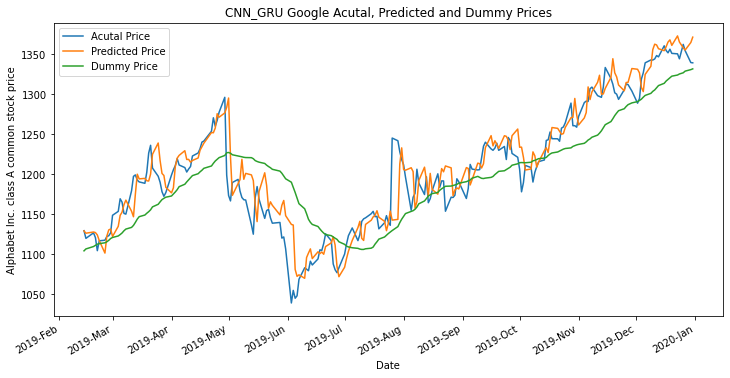

In [27]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

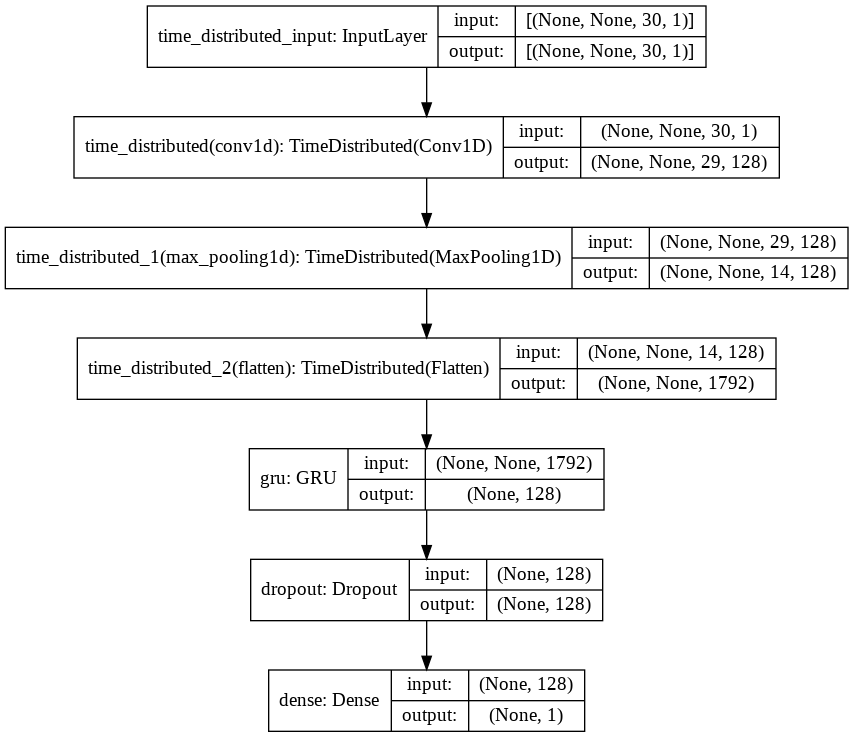

In [28]:
plot_model(model, show_shapes=True, expand_nested=True)

In [29]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.007785639973300752
RMSE:  0.08823627356875828
MAE:  0.06331924716794439
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [30]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Google/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Google/assets
